In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import joblib

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, plot_roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, f1_score, plot_roc_curve, roc_auc_score, accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from imblearn.over_sampling import RandomOverSampler

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


import thor

In [9]:
train = pd.read_csv('../data/total_train.csv')
test = pd.read_csv('../data/total_test.csv')

X = train.loc[0:20_000,'title']
y = train.loc[0:20_000,'class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

In [3]:
def change_threshold(probs, threshold):
    pos_probs = pd.Series([p[1] for p in probs])
    return pos_probs.map(lambda p: 1 if p>=threshold else 0)

def verbose_eval(estimator, data, actual, threshold=0.5):
    preds = change_threshold(estimator.predict_proba(data), threshold)
    ConfusionMatrixDisplay(confusion_matrix(actual, preds)).from_predictions(actual, preds);
    print(" ")
    print("Accuracy: ", accuracy_score(actual, preds))
    print(" ")
    print("Recall: ", recall_score(actual, preds))
    print(" ")
    print("Precision: ", precision_score(actual, preds))
    print(" ")
    print("F1: ", f1_score(actual, preds))
    print(" ")


---

# A Single Decision Tree

A **Decision Tree** is a model which classifies data by partition the feature space in rectangular subsets.
1. The partitioning happens in steps: first an input feature is selected, say $x_1$.
2. The model splits the feature space into two intervals $(x_1 < c)$ and $(x_1 \geq c)$. The optimal split point $c$ is decided on by the Gini impurity score.
3. Repeat this process until the data set is sufficiently partitioned and separated in the feature space.

In [10]:
%%time

pipe = Pipeline([
            ('cvec', CountVectorizer(max_df=0.3, binary=True, ngram_range=(1,4))),
            ('dt', DecisionTreeClassifier(max_depth=None, random_state=42, min_samples_leaf=5))
            ], 
        verbose=True)

gs = GridSearchCV(pipe, param_grid={}, cv=5, n_jobs=8)

gs.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 2) Processing cvec, total=   1.1s
[Pipeline] ................ (step 2 of 2) Processing dt, total=  13.6s
CPU times: total: 14.7 s
Wall time: 31.9 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(binary=True, max_df=0.3,
                                                        ngram_range=(1, 4))),
                                       ('dt',
                                        DecisionTreeClassifier(min_samples_leaf=5,
                                                               random_state=42))],
                                verbose=True),
             n_jobs=8, param_grid={})

In [5]:
%%time

pipe = Pipeline([
            ('cvec', CountVectorizer(max_df=0.3, binary=True, ngram_range=(1,4))),
            ('dt', DecisionTreeClassifier(max_depth=None, random_state=42, min_samples_leaf=5))
            ], 
        verbose=True)

gs = GridSearchCV(pipe, param_grid={}, cv=5, n_jobs=8)

gs.fit(X_train, y_train)

[Pipeline] .............. (step 1 of 2) Processing cvec, total=   4.9s
[Pipeline] ................ (step 2 of 2) Processing dt, total= 3.0min
CPU times: total: 3min 7s
Wall time: 7min 12s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(binary=True, max_df=0.3,
                                                        ngram_range=(1, 4))),
                                       ('dt',
                                        DecisionTreeClassifier(min_samples_leaf=5,
                                                               random_state=42))],
                                verbose=True),
             n_jobs=8, param_grid={})

In [30]:
pipe1 = Pipeline([
            ('cvec', CountVectorizer()),
            ('dt', DecisionTreeClassifier(random_state=42))
        ])

tree1_params = {
            'cvec__max_df':[0.3],
            'cvec__binary':[True],
            'cvec__ngram_range':[(1,3), (1,4)],
            'dt__max_depth':[None],
            'dt__min_samples_leaf':[5]
}

In [32]:
#tree1 = GridSearchCV(pipe1, tree1_params, cv=5, n_jobs=8)

#tree1.fit(X_train, y_train)

#joblib.dump(tree1, '../models/tree1.pkl')

tree1 = joblib.load('../models/tree1.pkl')

In [33]:
tree1.score(X_train, y_train), tree1.score(X_test, y_test)

(0.9120979078805921, 0.9111882907467129)

In [34]:
tree1.best_params_

{'cvec__binary': True,
 'cvec__max_df': 0.3,
 'cvec__ngram_range': (1, 3),
 'dt__max_depth': None,
 'dt__min_samples_leaf': 5}

 
Accuracy:  0.9104440585462664
 
Recall:  0.48188050930460335
 
Precision:  0.7182481751824817
 
F1:  0.5767878077373975
 


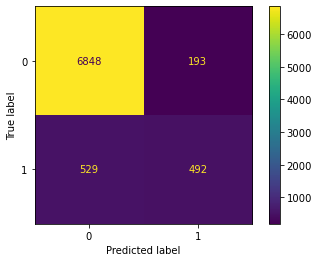

In [35]:
verbose_eval(tree1, X_test, y_test)

- Seems that the Decision Tree is doing worse than Naive Bayes and Logistic Regression. This isn't too surpring: Decision trees are known to be **Weak Classifiers** which means a *single* tree generally will not outperform more robust classifiers like Logistic Regression.
- That being said, the main advantage of Decision Trees when we start pooling them together to create **Ensembles**. This is what we will look at in the notebook 5 (file name is ```05-Ensemble-Methods.ipynb```